# Churn Prediction using Decision Tree with PySpark using ML Package

Before begin with Spark coding, Jupyter Note and Spark should be installed. Follows the steps to follow in Windows environment.

##### Install Jupyter in Windows: https://www.geeksforgeeks.org/how-to-install-jupyter-notebook-in-windows/

1. Download Anaconda: https://www.anaconda.com/distribution/#windows
2. Install Anaconda: https://www.geeksforgeeks.org/how-to-install-anaconda-on-windows/
3rd step is not required with latest Anaconda - Jupyter is installed with Anaconda.
3. Install Jupyter using Anaconda: https://www.geeksforgeeks.org/how-to-install-jupyter-notebook-in-windows/
4. Change Jupyter workspace: https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/execute.html
5. Then, run Jupyter using start menu: Not through Anaconda Nevigator


##### Install PySpark in Windows: https://changhsinlee.com/install-pyspark-windows-jupyter/

1. Download spark: https://www.apache.org/dyn/closer.lua/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
2. Install Anaconda with Jupyter: Did above
3. Download winutils: https://github.com/steveloughran/winutils/blob/master/hadoop-2.7.1/bin/winutils.exe
4. Install findspark: Launch Anaconda Prompt and run: python -m pip install findspark
5. Unpack spark to: D:\data\MSC-2020\Semester-1\DataScience-CS5617\Assignment01\JupytorNotebook\spark-2.4.5-bin-hadoop2.7
6. Copy winutils to spark bin
7. Set env vars
8. Run Jupyter

##### Data Preparation

This section covers the data preprocessing for churn model. 
Telecom data set will be loaded from CSV file which contains 9490 total records. It contains 14 columns with telecom user’s demographic data, behavioral data and transactional data including customer ID and customer churn status.
It will visualize and analize the data using pandas and remove correlated fields to imporve model accuracy.

In [1]:
################################## Data preprocessing: START ##########################################

import findspark
findspark.init()

import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").appName("Customer Churn").config("spark.driver.host", "localhost").getOrCreate()

# Disable warnings, set Matplotlib inline plotting and load Pandas package
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pandas as pd

In [2]:
##########load the CSV data set into DataFrames, keeping the header information and caching them into memory for quick, repeated access. Also print the schema of the sets.
telco_data_df = spark.read.option("header", "true").option('inferSchema', 'true').option("mode", "DROPMALFORMED").csv("D:\data\MSC-2020\Semester-1\DataScience-CS5617\Assignment01\TelcoChurnDataset.csv")
telco_data_df.cache()
telco_data_df.printSchema()

root
 |-- CustomerId: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- isCustomerSuspended: string (nullable = true)
 |-- CallDropRate: double (nullable = true)
 |-- NumberOfComplaints: integer (nullable = true)
 |-- MonthlyBilledAmount - Rs: integer (nullable = true)
 |-- UnpaidBalance - Rs: integer (nullable = true)
 |-- NumberOfMonthUnpaid: integer (nullable = true)
 |-- TotalMinsUsedInLastMonth: integer (nullable = true)
 |-- TotalCallDuration: integer (nullable = true)
 |-- AvgCallDuration: integer (nullable = true)
 |-- PercentageCallOutsideNetwork: double (nullable = true)
 |-- isChurned: string (nullable = true)



In [4]:
#use Pandas instead of the Spark DataFrame.show() function because it creates a prettier print.
pd.DataFrame(telco_data_df.take(5), columns=telco_data_df.columns)

#The describe() function performs summary statistics calculations on all numeric columns, and returns them as a DataFrame.
telco_data_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
CustomerId,9490,4745.5,2739.6713610699126,1,9490
Age,9490,45.35437302423604,19.61830213987055,12,79
Gender,9490,None,None,Female,Male
isCustomerSuspended,9490,None,None,No,Yes
CallDropRate,9490,0.035011591148576784,0.023008172142712332,0.0,0.07
NumberOfComplaints,9490,1.5024236037934668,1.118561446158692,0,3
MonthlyBilledAmount - Rs,9490,2087.920969441517,1039.6945854112168,300,3870
UnpaidBalance - Rs,9490,4106.165437302424,2112.764062651282,300,7770
NumberOfMonthUnpaid,9490,3.4973656480505797,2.289842819766248,0,7


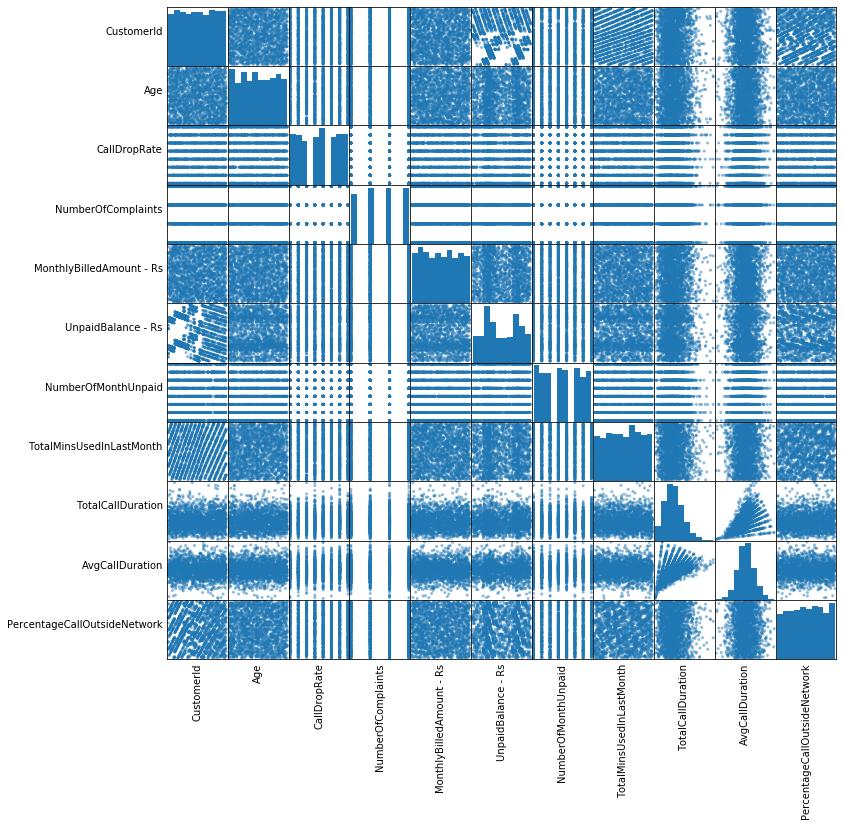

In [5]:
##########Use the Pandas library to examine correlations between the numeric columns by generating scatter plots of them.

#A randomly sample a portion of the data (10%) used for analysis
numeric_features = [t[0] for t in telco_data_df.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = telco_data_df.select(numeric_features).sample(False, 0.20).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(12, 12))

# Rotate axis labels and remove axis ticks
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [6]:
#TotalCallDuration and AvgCallDuration are correlated. Therefore drop one column of pair of correlated fields.

##########Final data preparation
#Transform the categorical data into numeric as required by the machine learning routines, using a simple user-defined function that maps Yes/Male and No/Female to 1 and 0, respectively.
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import UserDefinedFunction

binary_map = {'Yes':1.0, 'No':0.0, 'Male':1.0, 'Female':0.0}
toNum = UserDefinedFunction(lambda k: binary_map[k], DoubleType())

telco_data_final_df = telco_data_df.drop('TotalCallDuration') \
    .withColumn('Churn', toNum(telco_data_df['isChurned'])) \
    .withColumn('Gender', toNum(telco_data_df['Gender'])) \
    .withColumn('isCustomerSuspended', toNum(telco_data_df['isCustomerSuspended'])).cache()

pd.DataFrame(telco_data_final_df.take(5), columns=telco_data_final_df.columns)

################################## Data preprocessing: END ##########################################

,CustomerId,Age,Gender,isCustomerSuspended,CallDropRate,NumberOfComplaints,MonthlyBilledAmount - Rs,UnpaidBalance - Rs,NumberOfMonthUnpaid,TotalMinsUsedInLastMonth,AvgCallDuration,PercentageCallOutsideNetwork,isChurned,Churn
0,1,12,1.0,1.0,0.06,0,2430,870,7,15,663,0.82,No,0.0
1,2,42,0.0,1.0,0.05,1,540,1320,4,212,737,0.27,No,0.0
2,3,58,0.0,1.0,0.07,0,780,4620,2,216,624,0.48,No,0.0
3,4,20,1.0,1.0,0.05,1,2520,5070,7,412,834,0.94,No,0.0
4,5,36,1.0,1.0,0.07,0,2730,870,5,416,628,0.15,No,0.0


##### Predictive model Using the Spark ML Package

Decision Tree Model is generated using the training set and evaluated with the testing set. The cross validator will use the ParamGridBuilder to iterate through the maxDepth parameter of the decision tree and evaluate the models using the F1-score, repeating 3 times per parameter value for reliable results.

In [7]:
################################## Predictive model Using the Spark ML Package: START ##########################################

from pyspark.mllib.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler


#There are about 10 times as many False churn samples as True churn samples. So, stratified sampling is used to put the two sample types on the same footing. 
#Here we're keeping all instances of the Churn=True class, but downsampling the Churn=False class to a fraction of 858/8632.
telco_data_final_df.groupby('Churn').count().toPandas()
stratified_data = telco_data_final_df.sampleBy('Churn', fractions={0: 858./8632, 1: 1.0}).cache()
stratified_data.groupby('Churn').count().toPandas()	

,Churn,count
0,0.0,865
1,1.0,858


In [8]:
# Convert to vector with features
telco_data_final_cols = ["Age", "Gender", "isCustomerSuspended", "CallDropRate", "NumberOfComplaints", "MonthlyBilledAmount - Rs", "UnpaidBalance - Rs", "NumberOfMonthUnpaid", "TotalMinsUsedInLastMonth", "AvgCallDuration", "PercentageCallOutsideNetwork"]
assembler = VectorAssembler(inputCols=telco_data_final_cols, outputCol='features')
vectorized_stratified_data = assembler.transform(stratified_data)
vectorized_telco_data_final_df = assembler.transform(telco_data_final_df)

In [9]:
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='Churn', outputCol='indexedLabel').fit(vectorized_stratified_data)

# Index the features
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(vectorized_stratified_data)

# Split the data into training and test sets (20% held out for testing)
(trainingData, testData) = vectorized_telco_data_final_df.randomSplit([0.8, 0.2])
   
# Train a DecisionTree model
dTree = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dTree])

In [10]:
# Search through decision tree's maxDepth parameter for best model
paramGrid = ParamGridBuilder().addGrid(dTree.maxDepth, [2,3,4,5,6,7]).build()

# Set F-1 score as evaluation metric for best model selection
evaluator = MulticlassClassificationEvaluator(labelCol='indexedLabel',predictionCol='prediction', metricName='f1')    

# Set up 3-fold cross validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

# Train model.  This also runs the indexers.
churn_model = crossval.fit(vectorized_stratified_data)

In [11]:
# Fetch best model
tree_model = churn_model.bestModel.stages[2]
print(tree_model)

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_0c5a732f2dc2) of depth 7 with 115 nodes


In [12]:
#DecisionTreeClassificationModel (uid=DecisionTreeClassifier_0c5a732f2dc2) of depth 7 with 115 nodes
#Tree model produced using the cross-validation process is one with a depth of 7. So it is assumed that a tree depth of 7 will perform well.

#Predictions and Model Evaluation
predicted_data = churn_model.transform(testData)
print (evaluator.getMetricName(), 'accuracy:', evaluator.evaluate(predicted_data))

f1 accuracy: 0.6849696758911609


In [13]:
predictions = predicted_data.select('CustomerId', 'prediction')
predictions.toPandas().head()

,CustomerId,prediction
0,4,1.0
1,5,1.0
2,7,1.0
3,8,0.0
4,15,0.0


In [14]:
#Finally, write to csv
predictions.write.format("csv").option("header", "true").option("inferSchema", "true").option("delimiter", ",").save("D:\data\MSC-2020\Semester-1\DataScience-CS5617\Assignment01\DS-OUT.csv")
